In [91]:
from autogluon.tabular import TabularDataset, TabularPredictor
from ray import tune
import numpy as np
import math

In [92]:
#import data from Data/phil_socdata_train.csv, normalize (between 0 and 1) and standardize
train_data = TabularDataset('Data/phil_socdata_train.csv')

# drop the "T" column as it doesnt help with the prediction
train_data = train_data.drop(labels=['T'],axis=1)
train_data.head()


Loaded data from: Data/phil_socdata_train.csv | Columns = 6 / 6 | Rows = 421709 -> 421709


,SOC,V,I,T,V_avg,I_avg
0,100.000031,400.125,-1.50,16.5,400.125,-1.50
1,100.000031,400.125,-1.56,16.5,400.125,-1.53
2,100.000031,400.125,-1.62,16.5,400.125,-1.56
3,100.000031,400.125,-1.68,16.5,400.125,-1.59
4,100.000031,400.125,-1.74,16.5,400.125,-1.62


In [93]:
label = 'SOC'
train_data[label].describe()

count    421709.000000
mean         68.186101
std          24.503003
min           0.000000
25%          49.019623
50%          73.333359
75%          89.019638
max         100.000031
Name: SOC, dtype: float64

In [94]:
time_limit = 60  # train various models for x minutes

predictor = TabularPredictor(label=label).fit(
    train_data, 
    time_limit=time_limit, 
    presets='best_quality'
)



No path specified. Models will be saved in: "AutogluonModels/ag-20230405_190132/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to "AutogluonModels/ag-20230405_190132/"
AutoGluon Version:  0.7.0
Python Version:     3.10.8
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #148-Ubuntu SMP Mon Oct 17 16:02:06 UTC 2022
Train Data Rows:    421709
Train Data Columns: 5
Label Column: SOC
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (100.000030517578, 0.0, 68.1861, 24.503)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regr

In [95]:
# import test data from Data/phil_socdata_test.csv, normalize (between 0 and 1) and standardize
test_data1 = TabularDataset(f'Data/phil_socdata_test1.csv')
test_data2 = TabularDataset(f'Data/phil_socdata_test2.csv')

y_pred1= predictor.predict(test_data1.drop(columns=[label]))
y_pred1.head()

y_pred2= predictor.predict(test_data2.drop(columns=[label]))
y_pred2.head()

Loaded data from: Data/phil_socdata_test1.csv | Columns = 6 / 6 | Rows = 5617 -> 5617
Loaded data from: Data/phil_socdata_test2.csv | Columns = 6 / 6 | Rows = 18307 -> 18307


0    98.870476
1    98.870476
2    98.870476
3    98.870476
4    98.870476
Name: SOC, dtype: float32

In [96]:
predictor.evaluate(test_data1, silent=True)

/home/witvoetk/anaconda3/envs/tf/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


{'root_mean_squared_error': -2.2046877637171143,
 'mean_squared_error': -4.86064813548397,
 'mean_absolute_error': -1.5501796099558316,
 'r2': 0.9734162111225643,
 'pearsonr': 0.99086299386547,
 'median_absolute_error': -1.1150093034960946}

In [97]:
predictor.evaluate(test_data2, silent=True)

/home/witvoetk/anaconda3/envs/tf/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


{'root_mean_squared_error': -2.1920326960999734,
 'mean_squared_error': -4.8050073407713185,
 'mean_absolute_error': -1.5490273820260583,
 'r2': 0.9925689805076882,
 'pearsonr': 0.9979813518456417,
 'median_absolute_error': -1.0696563764160132}

In [98]:
predictor.leaderboard(test_data1, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT_BAG_L1,-1.906501,-1.365286,1.056135,53.810334,30.729506,1.056135,53.810334,30.729506,1,True,1
1,WeightedEnsemble_L2,-1.906501,-1.365286,1.057476,53.813781,30.735392,0.001341,0.003447,0.005885,2,True,2
2,LightGBMXT_BAG_L2,-2.204688,-1.165953,1.503800,71.739376,44.489804,0.447665,17.929042,13.760298,2,True,3
3,WeightedEnsemble_L3,-2.204688,-1.165953,1.505004,71.744381,44.497479,0.001203,0.005005,0.007675,3,True,4


In [99]:
predictor.leaderboard(test_data2, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT_BAG_L1,-2.149653,-1.365286,2.085970,53.810334,30.729506,2.085970,53.810334,30.729506,1,True,1
1,WeightedEnsemble_L2,-2.149653,-1.365286,2.087335,53.813781,30.735392,0.001364,0.003447,0.005885,2,True,2
2,LightGBMXT_BAG_L2,-2.192033,-1.165953,3.009794,71.739376,44.489804,0.923824,17.929042,13.760298,2,True,3
3,WeightedEnsemble_L3,-2.192033,-1.165953,3.012696,71.744381,44.497479,0.002902,0.005005,0.007675,3,True,4


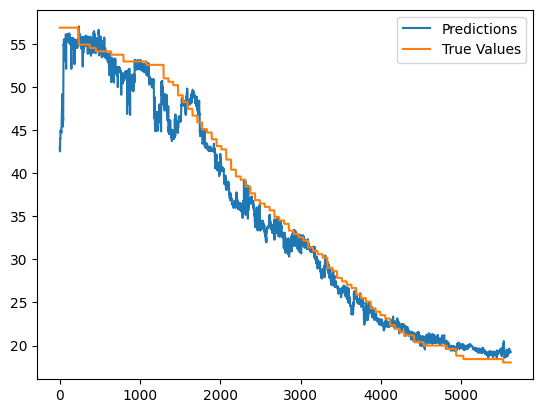

In [100]:
#plots the predicted vs actual values of the top performing model using matplotlib
import matplotlib.pyplot as plt
plt.plot(y_pred1, label="Predictions")
plt.plot(test_data1[label], label="True Values")
plt.legend()
plt.show()

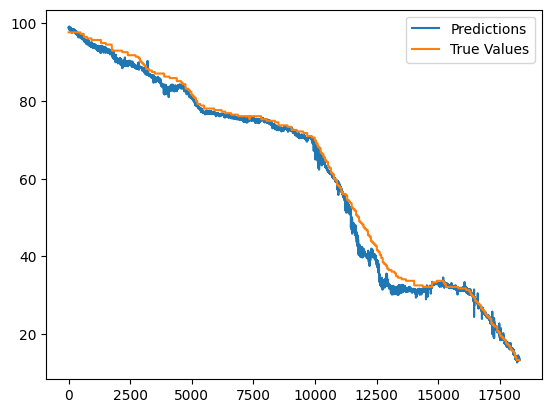

In [101]:
plt.plot(y_pred2, label="Predictions")
plt.plot(test_data2[label], label="True Values")
plt.legend()
plt.show()

In [102]:
mse_test = np.mean(((y_pred1 - test_data1[label])**2))
rmse_test = math.sqrt(mse_test)
print("Test data 1 RMSE", rmse_test)
mse_test = np.mean(((y_pred2 - test_data2[label])**2))
rmse_test = math.sqrt(mse_test)
print("Test data 2 RMSE", rmse_test)

Test data 1 RMSE 2.2046877637171143
Test data 2 RMSE 2.1920326960999734


In [103]:
predictor.feature_importance(test_data1)

Computing feature importance via permutation shuffling for 5 features using 5000 rows with 5 shuffle sets...
	40.75s	= Expected runtime (8.15s per shuffle set)
	25.41s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
V_avg,14.216962,0.329433,3.457084e-08,5,14.895268,13.538655
I_avg,3.710503,0.028994,4.473684e-10,5,3.770203,3.650803
V,3.123500,0.055465,1.192618e-08,5,3.237703,3.009297
I,1.298425,0.027384,2.372631e-08,5,1.354808,1.242041
T,-0.329771,0.018898,9.999987e-01,5,-0.290861,-0.368682


In [104]:
predictor.feature_importance(test_data2)

Computing feature importance via permutation shuffling for 5 features using 5000 rows with 5 shuffle sets...
	42.18s	= Expected runtime (8.44s per shuffle set)
	25.66s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
V_avg,22.701013,0.211608,9.058928e-10,5,23.136716,22.265309
V,13.018320,0.263529,2.013901e-08,5,13.560930,12.475710
I_avg,4.163572,0.127487,1.053517e-07,5,4.426070,3.901074
I,1.025777,0.014993,5.474576e-09,5,1.056647,0.994907
T,0.118000,0.007555,2.005252e-06,5,0.133555,0.102444
